In [ ]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
jiryanfarokhi_dataslayer_path = kagglehub.dataset_download('jiryanfarokhi/dataslayer')
jiryanfarokhi_data_slayer1_path = kagglehub.dataset_download('jiryanfarokhi/data-slayer1')
jiryanfarokhi_benchmark7_path = kagglehub.dataset_download('jiryanfarokhi/benchmark7')
eldintarofarrandi_benchmark123_path = kagglehub.dataset_download('eldintarofarrandi/benchmark123')
eldintarofarrandi_test_half_size_path = kagglehub.dataset_download('eldintarofarrandi/test-half-size')
eldintarofarrandi_output_full_size_path = kagglehub.dataset_download('eldintarofarrandi/output-full-size')
eldintarofarrandi_benchmark98_path = kagglehub.dataset_download('eldintarofarrandi/benchmark98')
eldintarofarrandi_0_95sa_path = kagglehub.dataset_download('eldintarofarrandi/0-95sa')

print('Data source import complete.')


Data source import complete.


## Motion Matters: Human Fall Detection Classification for Safety Insight
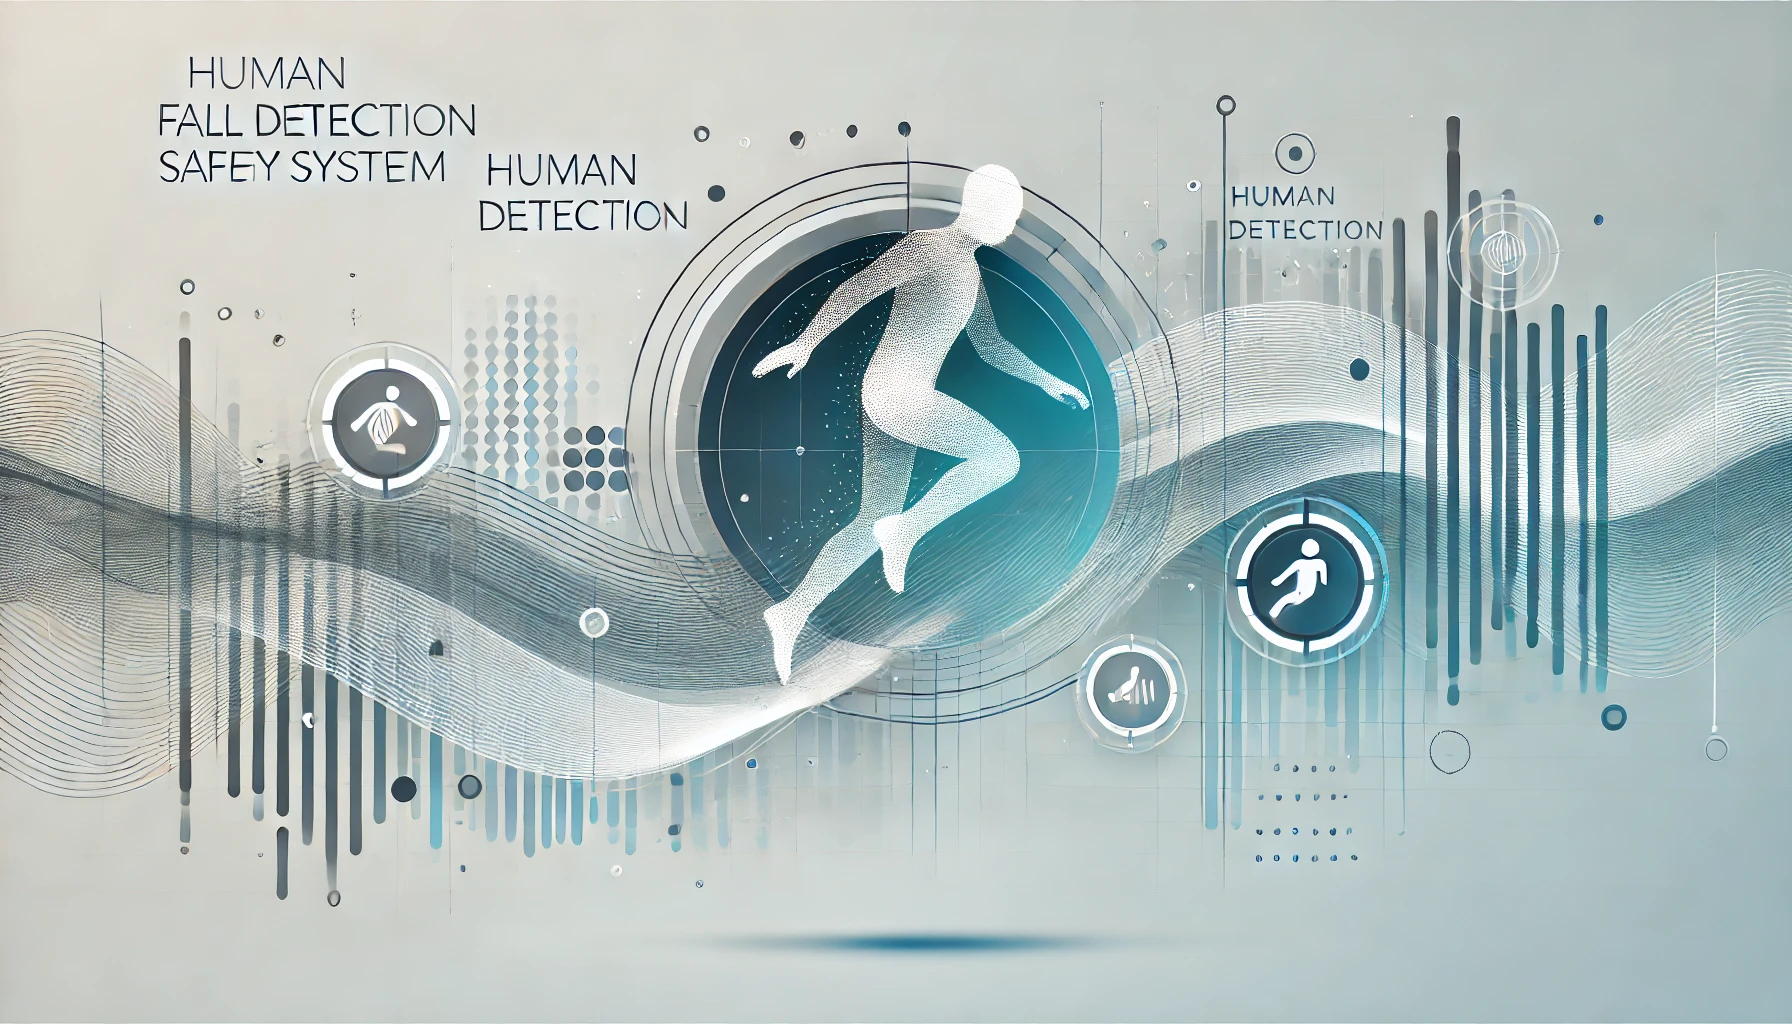

## Deskripsi Dataset
Data yang digunakan dalam kompetisi ini terdiri dari dua kategori gerakan utama, yaitu fall dan non_fall.

- Pada kategori fall, terdapat beberapa jenis gerakan yang termasuk di dalamnya, seperti backward falls, forward falls, left falls, right falls, sitting falls, dan standing falls. Sementara pada kategori non_fall, gerakan yang terdeteksi antara lain jumping, laying, picking, squat, stretching, dan walking. Dalam dataset ini, label 0 digunakan untuk kategori non_fall dan label 1 untuk kategori fall.

- Dataset train terdiri dari 4 subjek dengan berbagai tipe gerakan yang berbeda, dan peserta diharapkan untuk mengembangkan model yang dapat mengklasifikasikan frame-frame video berdasarkan gerakan tersebut.

- Data test yang disediakan berisi ribuan frame yang nantinya akan diklasifikasikan oleh peserta. Setiap frame pada masing-masing dataset memiliki resolusi 1280 x 720 piksel.

- Disediakan juga fail sample_submission.csv sebagai contoh untuk melakukan pengiriman prediksi. Fail tersebut memiliki dua kolom, yaitu id yang berisi nama data yang terdapat pada data *test *dan label yang berisi hasil prediksinya.

## Import Library

In [ ]:
import os
import random
import shutil
import csv
from collections import Counter, defaultdict, deque
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms, datasets
from torchvision.models import mobilenet_v3_large
from torchvision.transforms import Normalize

import albumentations as A
from albumentations import Compose, HorizontalFlip, ShiftScaleRotate, RandomBrightnessContrast, GaussNoise, Blur, ToFloat
from albumentations.pytorch import ToTensorV2

from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Pendahuluan
Notebook ini bertujuan untuk menyelesaikan masalah terkait klasifikasi gambar frame jatuh (<mark>fall</mark>) dan tidak jatuh (<mark>non_fall</mark>). Dalam proses ini, akan diterapkan beberapa pendekatan, termasuk metode berbasis Sistem Analisis serta Deep Learning. Metode - metode yang digunakan kemudian dievaluasi untuk membandingkan efektivitas dalam menyelesaikan permasalahan klasifikasi tersebut


## 2. Alur Penyelesaian


Diagram di atas merupakan gambaran umum mengenai tahapan-tahapan penyelesaian masalah yang dilakukan dalam notebook ini. Dalam melakukan pengklasifikasian data, kami menggunakan dua pendekatan sebagai berikut :
- Temporal Frame - Pendekatan ini menggunakan penggabungan frame dalam urutan tertentu melalui *stacking* (Menumpuk frame dalam beberapa tumpukan yang telah ditentukan) yang menggunakan model 3D.
- Single Frame - Pendekatan ini menggunakan frame per satuan yang akan diprediksi menggunakan model 2D.

Penjelasan lebih detail setiap tahapan dan metode yang digunakan dapat ditemukan di bab selanjutnya

## 3. Karakteristik Dataset
Pertama-tama, kami menganalisis distribusi dataset yang terdapat dalam folder train. Setelah itu kami, mencoba menganalisis karakteristik dari tiap dataset dan mencoba menentukan kriterianya tentang aspek yang membedakan gambar berkategori <mark> fall </mark> dan <mark> non fall </mark>.

Didapatkan hasil analisis kami bahwa rata-rata gambar yang bersifat <mark> fall </mark>  mempunyai tinggi yang lebih kecil dari lebar objek dan gambar yang bersifat <mark> nonfall </mark> mempunyai tinggi yang lebih besar dari lebar objek. Hal ini sesuai dengan formula dari karakteristik fall dan non fall itu sendiri yaitu H X W. Di mana H adalah Tinggi dan W adalah lebar objek.

Pada pendekatan Temporal Frame, kami melakukan proses <mark> stacking gambar </mark> untuk membuat gambar bertumpuk yang berurut dalam sebuah video. Kemudian diteruskan ke dalam model 3D CNN. Sedangkan pada pendekatan Single Frame Dataset kami membuat dua model untuk data test yang <mark> full size </mark> dan <mark> half size </mark>. Full size merupakan data pada test ketika object memiliki full body dari manusia. Sedangkan half size ketika object memiliki setengah body dari manusia. Setelah melalui tahap pemrosesan data tersebut dan tahap training pada kedua model tesebut. Kami melakukan <mark> pembagian pada test </mark> berdasarkan full size dan half size menggunakan YOLOv5 berdasarkan Object Detection. Hal ini dilakukan agar prediksi pada data test dapat <mark> sesuai dengan flow pengerjaan kami dan didapatkan hasil yang optimal </mark>.

## Preprocessing

Fungsi load_image_sequences menavigasi direktori ini secara rekursif:
- Subjek: Direktori tingkat pertama mewakili subjek individu.
- Label: Subdirektori di dalam setiap subjek berisi label aksi, seperti fall (jatuh) atau non_fall (tidak jatuh).
- Aksi: Subdirektori dalam label berisi folder untuk aksi tertentu, yang dapat memiliki nama unik.

Masing-masing kelompok data (fall_sequences dan non_fall_sequences) dibagi lagi menjadi:
- Data Latih (Train): 80% dari data digunakan untuk melatih model.
- Data Uji (Test): 20% dari data digunakan untuk evaluasi model.

Data latih dari kedua kelompok (train_fall dan train_non_fall) digabung menjadi satu daftar train_sequences. Data uji dari kedua kelompok (test_fall dan test_non_fall) juga digabung menjadi satu daftar test_sequences.

In [ ]:
def load_image_sequences(root_dir):
    sequences = []
    for subject in os.listdir(root_dir):
        subject_path = os.path.join(root_dir, subject)
        if not os.path.isdir(subject_path):
            continue
        for label in os.listdir(subject_path):
            label_path = os.path.join(subject_path, label)
            if not os.path.isdir(label_path):
                continue
            for action in os.listdir(label_path):
                action_path = os.path.join(label_path, action)
                if not os.path.isdir(action_path):
                    continue
                image_paths = sorted(glob(os.path.join(action_path, '*.jpg')))
                if len(image_paths) == 0:
                    continue
                action_name = "_".join(action.split('_')[1:]) if '_' in action else action
                sequences.append({
                    'subject': subject,
                    'label': label,
                    'action': action_name,
                    'image_paths': image_paths
                })
    return sequences

root_dir = os.path.join(jiryanfarokhi_dataslayer_path, 'train')
sequences = load_image_sequences(root_dir)

fall_sequences = [s for s in sequences if s['label'] == 'fall']
non_fall_sequences = [s for s in sequences if s['label'] == 'non_fall']

train_fall, train_non_fall = train_test_split(fall_sequences, test_size=0.2, random_state=42)
val_fall, val_non_fall = train_test_split(non_fall_sequences, test_size=0.2, random_state=42)

train_sequences = train_fall + train_non_fall
val_sequences = val_fall + val_non_fall

Kami  melakukan transformasi data gambar pada dataset yang telah dibagi menjadi data latih (train_sequences) dan data uji (test_sequences). Transformasi dilakukan menggunakan augmentasi untuk memperkaya data latih, sedangkan data uji hanya diberi transformasi dasar untuk menjaga konsistensi saat evaluasi model.

In [ ]:
def apply_transformations(sequences, transform):
    transformed_sequences = []
    for seq in sequences:
        transformed_images = []
        for img_path in seq['image_paths']:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = np.expand_dims(img, axis=2)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = np.array(img, dtype=np.uint8)
            augmented_img = transform(transforms.ToPILImage()(img))
            transformed_images.append(augmented_img)

        transformed_sequences.append({
            'subject': seq['subject'],
            'label': seq['label'],
            'action': seq['action'],
            'image_tensors': transformed_images
        })
    return transformed_sequences

augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_augmented = apply_transformations(train_sequences, augmentation)
val_transformed = apply_transformations(val_sequences, val_transform)


- Transformasi augmentation terdiri dari resize gambar, flip horizontal acak, rotasi acak, pemotongan acak, penyesuaian warna, konversi ke tensor, dan normalisasi.
- Transformasi val_transform melakukan resize gambar, konversi ke tensor, dan normalisasi untuk dataset validasi.
- Menerapkan pipeline augmentation pada dataset pelatihan untuk menghasilkan gambar yang teraugmentasi.
- Menerapkan pipeline val_transform pada dataset validasi untuk menghasilkan gambar yang distandardisasi.
- Hasil akhirnya adalah dua dataset (train_augmented dan val_transformed) yang siap digunakan dalam pelatihan dan validasi dengan gambar yang sudah diproses.

# Klasifikasi Menggunakan Temporal Frame

In [ ]:
def stack_consecutive_frames(sequences, stack_size=5):
    stacked_sequences = []
    for seq in sequences:
        images = seq['image_tensors']
        if len(images) < stack_size:
            continue
        for i in range(len(images) - stack_size + 1):
            stacked = torch.stack(images[i:i+stack_size])
            stacked_sequences.append({
                'subject': seq['subject'],
                'label': seq['label'],
                'action': seq['action'],
                'stacked_images': stacked
            })
    return stacked_sequences

train_stacked = stack_consecutive_frames(train_augmented, stack_size=5)
val_stacked = stack_consecutive_frames(val_transformed, stack_size=5)

for i, sample in enumerate(train_stacked[:5]):
    assert sample['stacked_images'].shape == (5, 3, 224, 224), f"Shape mismatch in train sample {i}: {sample['stacked_images'].shape}"
for i, sample in enumerate(val_stacked[:5]):
    assert sample['stacked_images'].shape == (5, 3, 224, 224), f"Shape mismatch in test sample {i}: {sample['stacked_images'].shape}"
print(f"Total stacked train sequences with albumentations: {len(train_stacked)}")
print(f"Total stacked test sequences with albumentations: {len(val_stacked)}")

class StackedActionDataset(Dataset):
    def __init__(self, stacked_sequences):
        self.stacked_sequences = stacked_sequences

    def __len__(self):
        return len(self.stacked_sequences)

    def __getitem__(self, idx):
        sequence = self.stacked_sequences[idx]
        images = sequence['stacked_images']
        label = 1 if sequence['label'] == 'fall' else 0
        images = images.permute(1, 0, 2, 3)
        return images, label

batch_size = 4

train_dataset = StackedActionDataset(train_stacked)
test_dataset = StackedActionDataset(val_stacked)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

- Fungsi stack_consecutive_frames memproses urutan gambar, memeriksa kecukupan jumlah gambar, dan menumpuk gambar berturut-turut menjadi tensor 5 gambar, menyimpannya bersama dengan informasi subjek, label, dan aksi dalam dictionary, lalu mengembalikan list berisi tumpukan gambar.
- Dataset pelatihan (train_augmented) dan pengujian (val_transformed) diproses menggunakan stack_consecutive_frames untuk menghasilkan urutan gambar bertumpuk (train_stacked dan val_stacked), yang kemudian diperiksa bentuknya untuk memastikan kesesuaian dengan (5, 3, 224, 224).
- Kelas StackedActionDataset mengimplementasikan metode __len__ untuk menghitung panjang dataset dan __getitem__ untuk mengambil tumpukan gambar dan label, dengan label "fall" diubah menjadi 1 dan "non-fall" menjadi 0, serta mempermutasikan gambar ke format (C, T, H, W).
- Dataset pelatihan dan pengujian dibungkus dalam DataLoader dengan batch_size=4, pengacakan untuk pelatihan, dan tanpa pengacakan untuk pengujian, siap digunakan untuk melatih model klasifikasi aksi.

In [ ]:
class Conv3DModelEnhanced(nn.Module):
    def __init__(self, pretrained=True):
        super(Conv3DModelEnhanced, self).__init__()

        self.backbone = models.video.mc3_18(pretrained=pretrained)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        for param in self.backbone.parameters():
            param.requires_grad = False

        for param in self.backbone.layer4.parameters():
            param.requires_grad = True

        self.attention = nn.Sequential(
            nn.Conv3d(num_ftrs, num_ftrs, kernel_size=1),
            nn.BatchNorm3d(num_ftrs),
            nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 2)
        )
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        x = self.backbone(x)
        N = x.size(0)
        x = x.view(N, 512, 1, 1, 1)
        attn = self.attention(x)
        x = x * attn
        x = torch.mean(x, dim=(2, 3, 4))
        x = self.fc(x)
        return x



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Conv3DModelEnhanced(pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

Model **`Conv3DModelEnhanced`** adalah model deep learning berbasis arsitektur 3D convolution yang dirancang untuk tugas klasifikasi video dengan menggunakan kerangka **`MC3_18`** sebagai backbone. Backbone ini merupakan bagian dari keluarga ResNet yang dimodifikasi untuk data temporal dengan menggabungkan konvolusi 3D untuk menangkap hubungan spasial dan temporal. Lapisan fully connected (FC) bawaan backbone dihilangkan, dan diganti dengan lapisan **`Identity`**, memungkinkan penyesuaian lebih lanjut.

Model ini memiliki mekanisme **attention** berbasis 3D convolution, yang menggunakan fitur dari backbone untuk menghitung pentingnya setiap fitur dalam dimensi temporal dan spasial. Setelah melalui attention, fitur difokuskan kembali untuk meningkatkan kemampuan representasi model. Selain itu, model menggunakan **classifier custom** dengan beberapa lapisan fully connected yang dilengkapi dengan **batch normalization**, **LeakyReLU** sebagai fungsi aktivasi, dan **dropout** untuk mengurangi overfitting. Akhirnya, model menghasilkan prediksi dengan dua kelas (misalnya, "Fall" dan "Non-Fall") melalui lapisan **output linear**.

Model ini dilatih menggunakan **`AdamW`** sebagai optimizer, dengan pengurangan learning rate secara bertahap menggunakan **`StepLR`** untuk mengontrol stabilitas selama pelatihan. Secara keseluruhan, arsitektur ini menggabungkan kekuatan feature extraction berbasis video dengan mekanisme perhatian dan regularisasi modern untuk meningkatkan performa klasifikasi.

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_train / total_train
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    scheduler.step()

In [ ]:
class TestingDataset(Dataset):
    def __init__(self, image_dir, transform=None):

        self.image_paths = glob(os.path.join(image_dir, '*'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = -1

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Image not found or unable to read: {img_path}")

        img = np.expand_dims(img, axis=2)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = np.array(img, dtype=np.uint8)

        if self.transform:
            img = self.transform(img)

        return img, label, img_path


test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_directory = os.path.join(jiryanfarokhi_dataslayer_path, 'test')
testing_dataset = TestingDataset(image_dir=test_directory, transform=test_transform)
testing_loader = DataLoader(testing_dataset, batch_size=1, shuffle=False)

In [ ]:
def evaluate_testing(model, testing_loader, device, stack_size=5, num_samples=50, csv_path):

    model.eval()

    all_preds = []
    all_paths = []

    sample_images = []
    sample_preds = []
    sample_paths = []

    total_samples = len(testing_loader.dataset)

    num_samples = min(num_samples, total_samples)

    random_indices = set(random.sample(range(total_samples), num_samples))

    with torch.no_grad():
        for batch_idx, (images, labels, img_paths) in enumerate(testing_loader):
            images = images.to(device)
            labels = labels.to(device)

            frame = images[0]

            stacked_frames = frame.unsqueeze(1).repeat(1, stack_size, 1, 1)
            stacked_frames = stacked_frames.unsqueeze(0)

            assert stacked_frames.dim() == 5, f"Expected 5D tensor, got {stacked_frames.dim()}D tensor"

            outputs = model(stacked_frames)
            _, predicted = torch.max(outputs, 1)

            pred_label = predicted.item()

            img_path = img_paths[0]
            img_filename = os.path.basename(img_path)

            all_preds.append(pred_label)
            all_paths.append(img_filename)

            if batch_idx in random_indices and len(sample_images) < num_samples:
                img = frame.cpu().numpy()
                img = np.transpose(img, (1, 2, 0))  # [H, W, C]
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                sample_images.append(img)
                sample_preds.append(pred_label)
                sample_paths.append(img_filename)

    df = pd.DataFrame({
        'id': all_paths,
        'label': all_preds
    })

    df.to_csv(csv_path, index=False)

    print(f'Predictions saved to {csv_path}')

    distribution = df['label'].value_counts().sort_index()
    labels = ['NonFall', 'Fall']
    counts = distribution.tolist()
    plt.figure(figsize=(8,6))
    plt.bar(labels, counts, color=['blue', 'orange'])
    plt.title('Distribution of Predictions')
    plt.xlabel('Class')
    plt.ylabel('Count')
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    plt.show()

    num_plots = len(sample_images)
    cols = 6
    rows = (num_plots + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axes = axes.flatten()

    for i in range(num_plots):
        axes[i].imshow(sample_images[i])
        axes[i].set_title(f'Path: {sample_paths[i]}\nPredicted: {sample_preds[i]}')
        axes[i].axis('off')

    for i in range(num_plots, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


evaluate_testing(model, testing_loader, device, stack_size=5, num_samples=50, csv_path='predictions_temp.csv')

# Klasifikasi Menggunakan Single Frame

Kami membuat dataset PyTorch berbasis frame tunggal dari dataset aksi (Single Frame Action), yang berisi urutan gambar yang telah melalui proses transformasi. Selain itu, kami mengonversi dataset ke dalam DataLoader untuk melatih model deep learning dengan <mark>mini</mark> batch yang diacak.

In [ ]:
class SingleFrameActionDataset(Dataset):
    def __init__(self, sequences):
        self.data = []

        for seq in sequences:
            label = 1 if seq['label'] == 'fall' else 0
            for img_tensor in seq['image_tensors']:
                self.data.append((img_tensor, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label

train_single_frame_dataset = SingleFrameActionDataset(train_augmented)
test_single_frame_dataset = SingleFrameActionDataset(val_transformed)

batch_size = 4
train_single_frame_loader = DataLoader(train_single_frame_dataset, batch_size=batch_size, shuffle=True)
test_single_frame_loader = DataLoader(test_single_frame_dataset, batch_size=batch_size, shuffle=False)

for images, labels in train_single_frame_loader:
    assert images.shape[1:] == (3, 224, 224), f"Shape mismatch in batch: {images.shape}"
    print(f"Batch size: {images.shape[0]}, Image shape: {images.shape[1:]}")
    break

print(f"Total single frame train samples: {len(train_single_frame_dataset)}")
print(f"Total single frame test samples: {len(test_single_frame_dataset)}")

# Model

## Full Size

In [ ]:
class MobileNetV3Berdiri(nn.Module):
    def __init__(self, pretrained=True):
        super(MobileNetV3Berdiri, self).__init__()

        self.mobilenet = models.mobilenet_v3_large(pretrained=pretrained)
        num_ftrs_mobilenet = self.mobilenet.classifier[0].in_features
        self.mobilenet.classifier = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs_mobilenet, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        mobilenet_features = self.mobilenet(x)
        output = self.classifier(mobilenet_features)
        return output

Model **`MobileNetV3Berdiri`** adalah model deep learning berbasis arsitektur **MobileNetV3-Large**, yang dioptimalkan untuk tugas klasifikasi gambar dengan efisiensi tinggi. Backbone **MobileNetV3-Large** digunakan sebagai feature extractor, di mana lapisan classifier bawaan digantikan oleh **`Identity`**, sehingga hanya fitur yang diekstraksi tanpa menghasilkan output prediksi langsung.

Setelah fitur diekstraksi oleh backbone, model menggunakan classifier custom yang terdiri dari beberapa lapisan fully connected dengan ukuran awal 512 neuron. Lapisan ini dilengkapi dengan **batch normalization**, fungsi aktivasi **ReLU**, dan **dropout** untuk mengurangi overfitting. Akhirnya, model menghasilkan output dua kelas melalui lapisan linear terakhir.

## Half Size

In [ ]:
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()

        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )

        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_attention(x)
        x = x * ca

        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        sa_input = torch.cat([avg_out, max_out], dim=1)
        sa = self.spatial_attention(sa_input)
        x = x * sa

        return x

class MobileNetV3TidakBerdiri(nn.Module):
    def __init__(self, pretrained=True):
        super(MobileNetV3TidakBerdiri, self).__init__()

        self.mobilenet = models.mobilenet_v3_large(pretrained=pretrained)
        num_ftrs_mobilenet = self.mobilenet.classifier[0].in_features
        self.mobilenet.classifier = nn.Identity()

        self.cbam = CBAM(channels=num_ftrs_mobilenet)

        self.residual_conv = nn.Conv2d(num_ftrs_mobilenet, num_ftrs_mobilenet, kernel_size=1)

        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs_mobilenet, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        features = self.mobilenet.features(x)

        attention_features = self.cbam(features)

        if features.size() == attention_features.size():
            features = features + attention_features
        else:
            features = self.residual_conv(features) + attention_features

        pooled_features = nn.AdaptiveAvgPool2d(1)(features)
        pooled_features = torch.flatten(pooled_features, 1)

        output = self.classifier(pooled_features)
        return output


Model **`MobileNetV3TidakBerdiri`** adalah model klasifikasi gambar yang menggabungkan efisiensi backbone **MobileNetV3-Large** dengan mekanisme perhatian tambahan berbasis **CBAM (Convolutional Block Attention Module)**. MobileNetV3 digunakan sebagai feature extractor, di mana lapisan classifier bawaan dihapus dan digantikan oleh lapisan custom. Fitur yang dihasilkan oleh backbone diproses lebih lanjut oleh CBAM, yang secara adaptif memberikan perhatian pada saluran dan dimensi spasial untuk meningkatkan representasi fitur penting.

CBAM bekerja melalui dua tahap: **channel attention**, yang memprioritaskan saluran berdasarkan informasi global, dan **spatial attention**, yang memfokuskan perhatian pada lokasi spasial penting. Untuk menjaga konsistensi dimensi, model menggunakan koneksi residual yang menggabungkan fitur asli dan fitur yang diperkuat oleh CBAM. Setelah itu, fitur diringkas menggunakan **adaptive average pooling**, diratakan, dan diproses oleh lapisan fully connected yang dilengkapi dengan **batch normalization**, **ReLU**, dan **dropout** untuk klasifikasi dua kelas.

Model ini dioptimalkan menggunakan **AdamW**, dengan pengaturan learning rate yang disesuaikan melalui scheduler **StepLR**. Dengan penambahan CBAM dan fine-tuning pada MobileNetV3, model ini dirancang untuk menghasilkan performa yang lebih baik dalam klasifikasi dengan mempertahankan efisiensi komputasi.

In [ ]:
model_stand = MobileNetV3Berdiri(pretrained=True).to(device)
criterion_stand = nn.CrossEntropyLoss()
optimizer_stand = torch.optim.AdamW(model_stand.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_stand = torch.optim.lr_scheduler.StepLR(optimizer_stand, step_size=3, gamma=0.7)

In [ ]:
def fine_tune_model(model):
    for param in model.mobilenet.parameters():
        param.requires_grad = True

model_not_stand = MobileNetV3TidakBerdiri(pretrained=True).to(device)
fine_tune_model(model_not_stand)

criterion_not_stand = nn.CrossEntropyLoss()
optimizer_not_stand = torch.optim.AdamW(model_not_stand.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_not_stand = torch.optim.lr_scheduler.StepLR(optimizer_not_stand, step_size=3, gamma=0.7)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, num_epochs=10, save_path=None):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_train / total_train
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_loss)
        else:
            scheduler.step()

    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss = running_loss / total
    test_accuracy = correct / total * 100
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    confusion_matrix(all_labels, all_predictions)

    return test_loss, test_accuracy

In [ ]:
train_model(
    model=model_stand,
    criterion=criterion_stand,
    optimizer=optimizer_stand,
    scheduler=scheduler_stand,
    train_loader=train_single_frame_loader,
    num_epochs=3,
    save_path="mobilenetv3_berdiri_model.pth"
)

evaluate_model(
    model=model_stand,
    test_loader=test_single_frame_loader,
    criterion=criterion_stand
)

In [ ]:
train_model(
    model=model_not_stand,
    criterion=criterion_not_stand,
    optimizer=optimizer_not_stand,
    scheduler=scheduler_not_stand,
    train_loader=train_single_frame_loader,
    num_epochs=3,
    save_path="mobilenetv3_tidak_berdiri_model.pth"
)

evaluate_model(
    model=model_not_stand,
    test_loader=test_single_frame_loader,
    criterion=criterion_not_stand
)

# Deteksi Objek dengan YOLO dan Evaluasi

In [ ]:
test_directory = os.path.join(jiryanfarokhi_dataslayer_path, 'test')
BOUNDARY_RATIO = 0.5
device = 'cpu'

print("Loading YOLO model...")
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', device=device, force_reload=False)

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class TestingDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob(os.path.join(image_dir, '*'))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Image not found or unable to read: {img_path}")

        img = np.expand_dims(img, axis=2)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, img_path

testing_dataset = TestingDataset(image_dir=test_directory, transform=data_transform)
testing_loader = DataLoader(testing_dataset, batch_size=1, shuffle=False)


model_berdiri = MobileNetV3Berdiri(pretrained=False).to(device)
model_tidak_berdiri = MobileNetV3TidakBerdiri(pretrained=False).to(device)

model_berdiri.load_state_dict(torch.load("mobilenetv3_berdiri_model.pth", map_location=device))
model_tidak_berdiri.load_state_dict(torch.load("mobilenetv3_tidak_berdiri_model.pth", map_location=device))

model_berdiri.eval()
model_tidak_berdiri.eval()

print("Starting pipeline...")
results = []

HEAD_REGION_FRACTION = 0.2

for images, img_paths in tqdm(testing_loader, desc="Processing images"):
    images = images.to(device)

    img_path = img_paths[0]
    with torch.no_grad():
        yolo_results = yolo_model(img_path)
    detections = yolo_results.xyxy[0].cpu().numpy()

    img = Image.open(img_path)
    frame_width, frame_height = img.size
    boundary_y = int(BOUNDARY_RATIO * frame_height)
    is_berdiri = any(
        int(cls) == 0
        and (box[1] + HEAD_REGION_FRACTION * (box[3] - box[1])) <= boundary_y
        for *box, conf, cls in detections
    )

    if is_berdiri:
        with torch.no_grad():
            outputs = model_berdiri(images)
            _, predicted = torch.max(outputs, 1)
            label = 1 if predicted.item() == 1 else 0
    else:
        with torch.no_grad():
            outputs = model_tidak_berdiri(images)
            _, predicted = torch.max(outputs, 1)
            label = 1 if predicted.item() == 1 else 0

    results.append({"id": os.path.basename(img_path), "label": label})

csv_file = "results.csv"
with open(csv_file, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=["id", "label"])
    writer.writeheader()
    writer.writerows(results)

labels = [result["label"] for result in results]
label_counts = Counter(labels)

print("\n=== Label Distribution ===")
for label, count in label_counts.items():
    label_name = "fall" if label == 1 else "non_fall"
    print(f"{label_name}: {count}")

print(f"\nPipeline complete. Results saved to '{csv_file}'.")

# Kesimpulan
- <p style="font-size:18px;">Kualitas Dataset: Dataset yang kami gunakan sangat tidak bersih, sehingga memerlukan langkah pra-pemrosesan yang intensif untuk memastikan data siap digunakan dalam pemodelan.

- <p style="font-size:18px;">Untuk klasifikasi gerakan non_fall dan fall, didapatkan akurasi sebesar 0.93 dengan metode Temporal Frame dan didapatkan akurasi sebesar 0.95 dengan metode Single Frame yang keduanya merupakan skor yang didapatkan di sistem Kaggle. Metode yang kami gunakan dalam Temporal Frame berdasarkan paper dari [link text](https://pmc.ncbi.nlm.nih.gov/articles/PMC9470335/#sec4) menunjukkan performa yang cukup. Akan tetapi, jika dibandingkan menggunakan single frame didapatkan performa yang lebih bagus. Metode single frame berdasarkan analisis kami pada data train yang disediakan terhadap anomali data yang bisa saja diprediksi salah oleh metode sebelumnya.

- <p style="font-size:18px;"> Model : Dalam melakukan deteksi menggunakan metode Single Frame kita menggunakan arsitektur Mobilenet_v3_large dan untuk metode Temporal Frame menggunakan arsitektur M3D_18 dengan penambahan Attention Layer


- <p style="font-size:18px;" Proses Deteksi Gambar > Kami menggunakan arsitektur YOLO_V5 untuk proses deteksi gambar untuk membedakan berdiri dan tidak_berdiri.
